## 0- Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

## 1- Bussines Understanding

### Rossmann Store Sales  

Opera más de 3.000 farmacias en 7 países europeos. Actualmente, los gerentes de las tiendas Rossmann tienen la tarea de predecir sus ventas diarias con hasta seis semanas de anticipación. Las ventas en las tiendas están influenciadas por muchos factores, incluidas las promociones, la competencia, las vacaciones escolares y estatales, la estacionalidad y la localidad. Con miles de gerentes individuales que predicen las ventas en función de sus circunstancias únicas, la precisión de los resultados puede variar bastante.  

Objetivo: explorar datos y predecir 6 semanas de ventas diarias para 1115 tiendas ubicadas en Alemania.  
Este cuaderno se centra principalmente en el análisis de series de tiempo, un tema que no se trata en Rossmann Competition Kernels. Luego discutimos las ventajas y los inconvenientes del modelado con Seasonal ARIMA y Prophet.  

Como suele suceder, comenzamos con el Análisis de datos exploratorios de las principales métricas que revelan las tendencias y patrones actuales en los datos, lo que proporciona una base sólida para el análisis causal adicional.  

Además, como alternativa a la previsión con Prophet, utilizamos uno de los algoritmos de aumento de gradiente extremo más robustos y  Extreme Gradient Boosting for regression.

## 2- Data Understanding

Data fields  
Most of the fields are self-explanatory. The following are descriptions for those that aren't.  

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all - schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Read data

In [2]:
df = pd.read_csv('store.csv')

In [3]:
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [2]:
train = pd.read_csv('train.csv', index_col=['Date'], parse_dates=True)
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Short description:

- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools. 

We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.

In [7]:
df.shape, train.shape, test.shape

((1115, 10), (1017209, 8), (41088, 8))

### Exploratory Data Analysis (EDA)

#### Missing Values

In [11]:
df.isnull().sum().sort_values(ascending=False)

Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
CompetitionDistance            3
Store                          0
StoreType                      0
Assortment                     0
Promo2                         0
dtype: int64

##### Nota:
- Posee Nan Values

##### Filling Missing Values

In [68]:
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

In [69]:
df.fillna(0, inplace=True)

#### Explore Categorical Features

In [15]:
cat_features = df.select_dtypes('object').columns.tolist()
cat_features

['StoreType', 'Assortment', 'PromoInterval']

In [16]:
len(cat_features)

3

In [17]:
#imprimir la cantidad de valores unicos
for col in cat_features:
    print('La variable {}, tiene {} valores'.format(col, df[col].nunique()))

La variable StoreType, tiene 4 valores
La variable Assortment, tiene 3 valores
La variable PromoInterval, tiene 3 valores


#### Find Categorical Features distribution

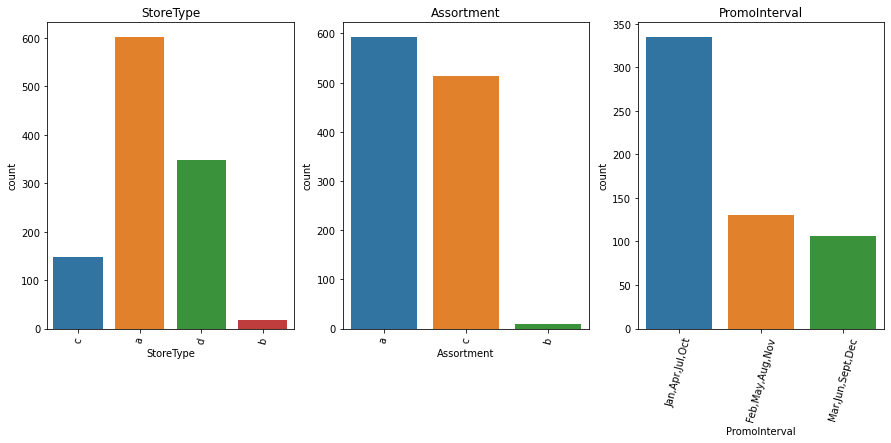

In [18]:
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for cat in cat_features:
    ax = plt.subplot(12,3, plotnumber)
    sns.countplot(x= cat, data = df)
    plt.xlabel(cat)
    plt.title(cat)
    plt.xticks(rotation= 75)
    plotnumber = plotnumber+1
plt.show()

##### Comentarios:
- el tipo de tienda a posee la mayor cantidad de registros
- el tipo de Assortment o surtido es el basico
- la temporada de mayor promoción es jan, april, jul, oct

### Adding new variables to train dataset

In [4]:
train['year']= train.index.year
train['month']= train.index.month
train['days']= train.index.day
train['weekofyear']= train.index.weekofyear
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,days,weekofyear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31


In [5]:
train['salespercustomers'] = train['Sales']/train['Customers']
train['salespercustomers'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: salespercustomers, dtype: float64

##### Comentario:  
- el average de ventas por clientes es de 9.49 dolares

#### ECDF: empirical cumulative distribution function

In [19]:
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

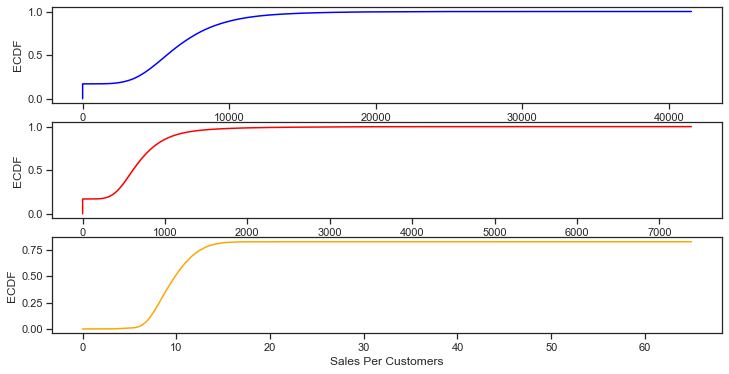

In [25]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label= 'statsmodels', color ='blue')
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label= 'statsmodels', color ='red')
plt.xlabel('Customers')
plt.ylabel('ECDF')

plt.subplot(313)
cdf = ECDF(train['salespercustomers'])
plt.plot(cdf.x, cdf.y, label= 'statsmodels', color ='orange')
plt.xlabel('Sales Per Customers')
plt.ylabel('ECDF')

plt.show()

#### Distribución de las ventas

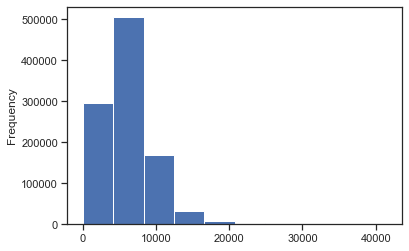

In [37]:
train['Sales'].plot.hist(bins= 10);

In [41]:
sin_ventas = train[train['Sales']==0].head()
sin_ventas

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,days,weekofyear,salespercustomers
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [40]:
len(train[train['Sales']==0])

172871

In [48]:
sin_ventas.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-30', '2015-07-30',
               '2015-07-29'],
              dtype='datetime64[ns]', name='Date', freq=None)

##### Tiendas abiertas sin ventas

In [56]:
len(train[(train['Open']!=0) & (train['Sales']==0)])

54

##### Comentario:  
- Hay 172,871 tiendas sin ventas 
- comprendido entre '2015-07-29' y '2015-07-31'
- hay 54 tiendas que fueron abiertas sin ventas

#### filtrado de train

In [6]:
train = train[(train['Open']!=0) & (train['Sales']!=0)]

In [7]:
train.shape

(844338, 13)

In [ ]:
train.to_csv('train_cleaned.csv')

### Join train and df

In [72]:
data = pd.merge(train, df, how='inner', on='Store')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,...,salespercustomers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [73]:
data.shape

(844338, 22)

In [89]:
data.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'month', 'days', 'weekofyear',
       'salespercustomers', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [135]:
data.to_csv('stores_train.csv', index=True)

#### Store type

In [86]:
data.groupby('StoreType')['Sales'].mean().sort_values(ascending=False)

StoreType
b    10233.380141
c     6933.126425
a     6925.697986
d     6822.300064
Name: Sales, dtype: float64

In [88]:
data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


**Nota:**
- el tipo de tienda B es la de mayor promedio de ventas
- Las ventas minimas de B son mayores que las demas
- el tipo de tienda a optiene ventas maximas de 41,551

In [83]:
data.groupby('StoreType')[['Sales', 'Customers']].sum().sort_values(by = 'Sales', ascending=False)

,Sales,Customers
StoreType,,
a,3165334859,363541431
d,1765392943,156904995
c,783221426,92129705
b,159231395,31465616


**Nota:**  
- La tienda a y d tiene mayor volumen de ventas y clientes

###  Análisis de las tendencias de las ventas-Promo

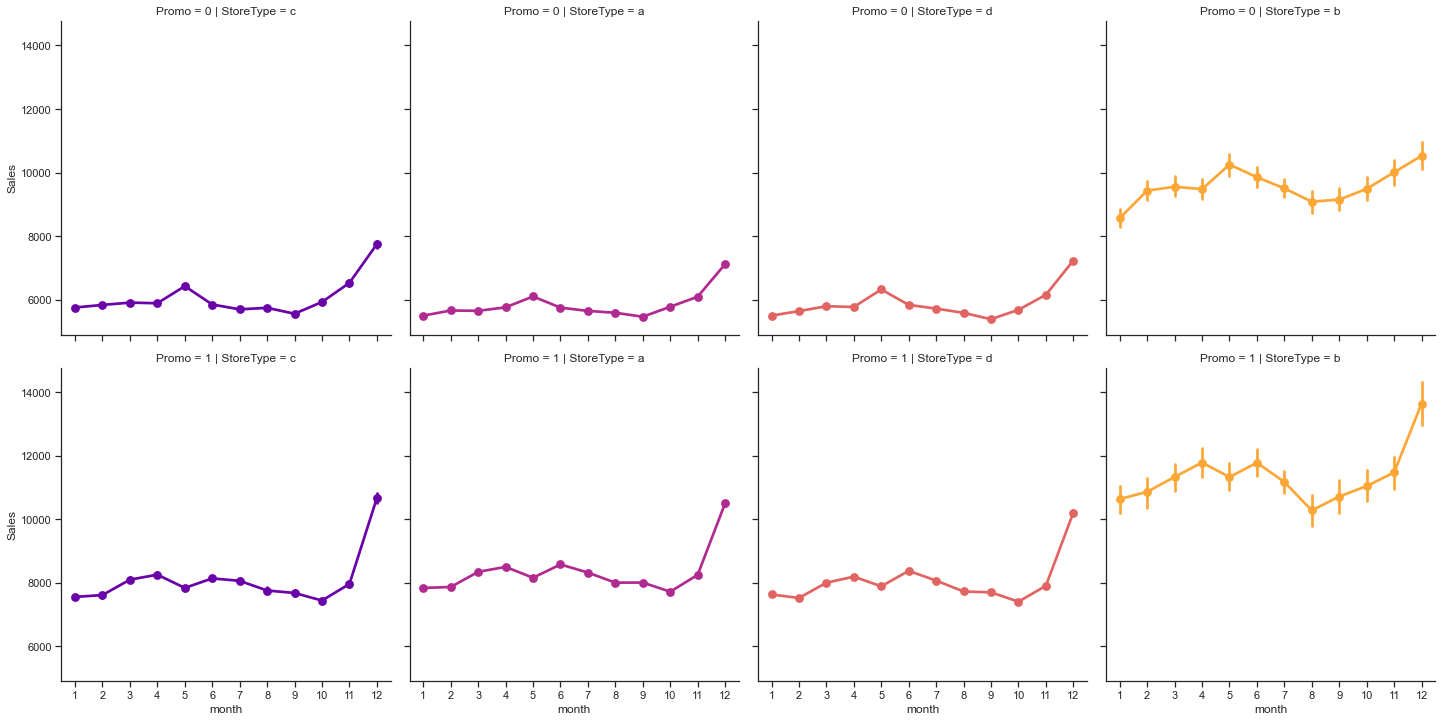

In [95]:
# Tendencia de las ventas
sns.factorplot(data = data, x= 'month', y = 'Sales', col = 'StoreType',
              hue = 'StoreType',
              row= 'Promo', palette = 'plasma');

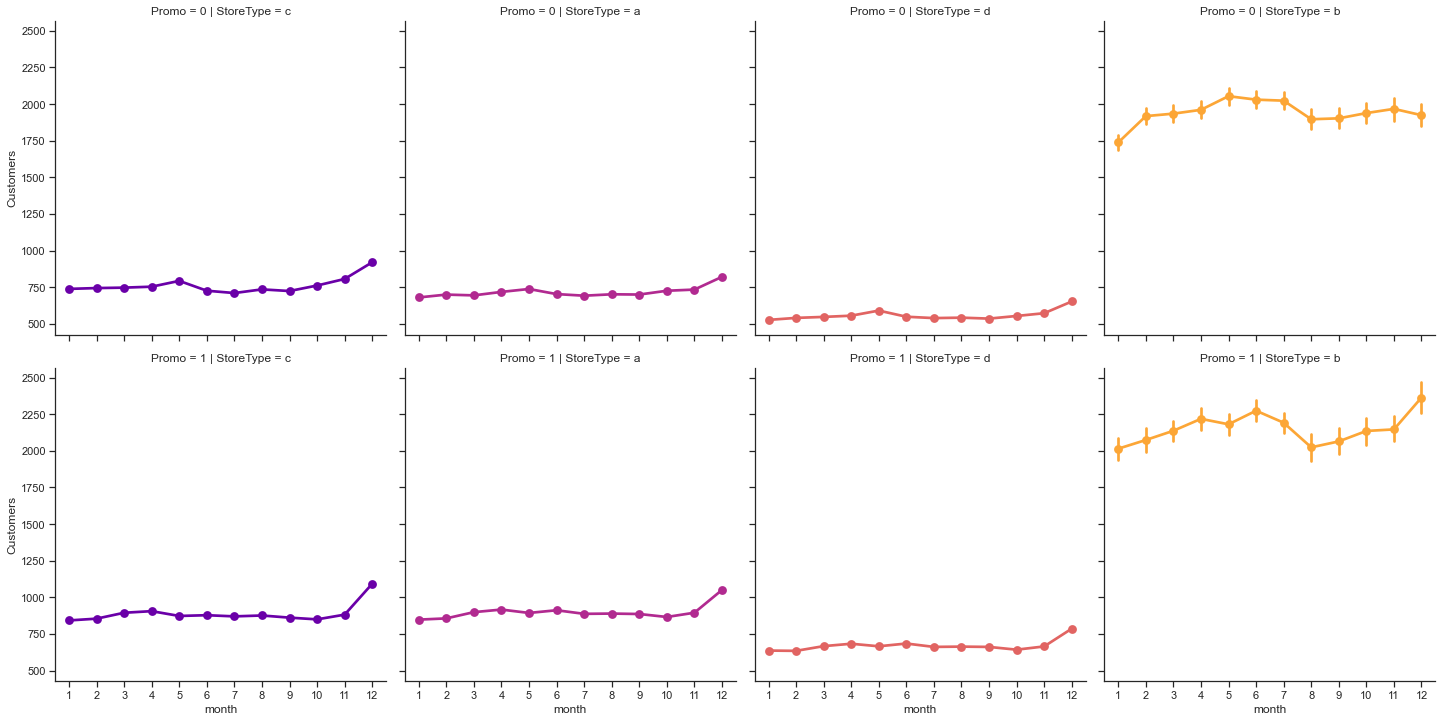

In [93]:
# Tendencia de las ventas
sns.factorplot(data = data, x= 'month', y = 'Customers', col = 'StoreType',
              hue = 'StoreType',
              row= 'Promo', palette = 'plasma')
plt.show()

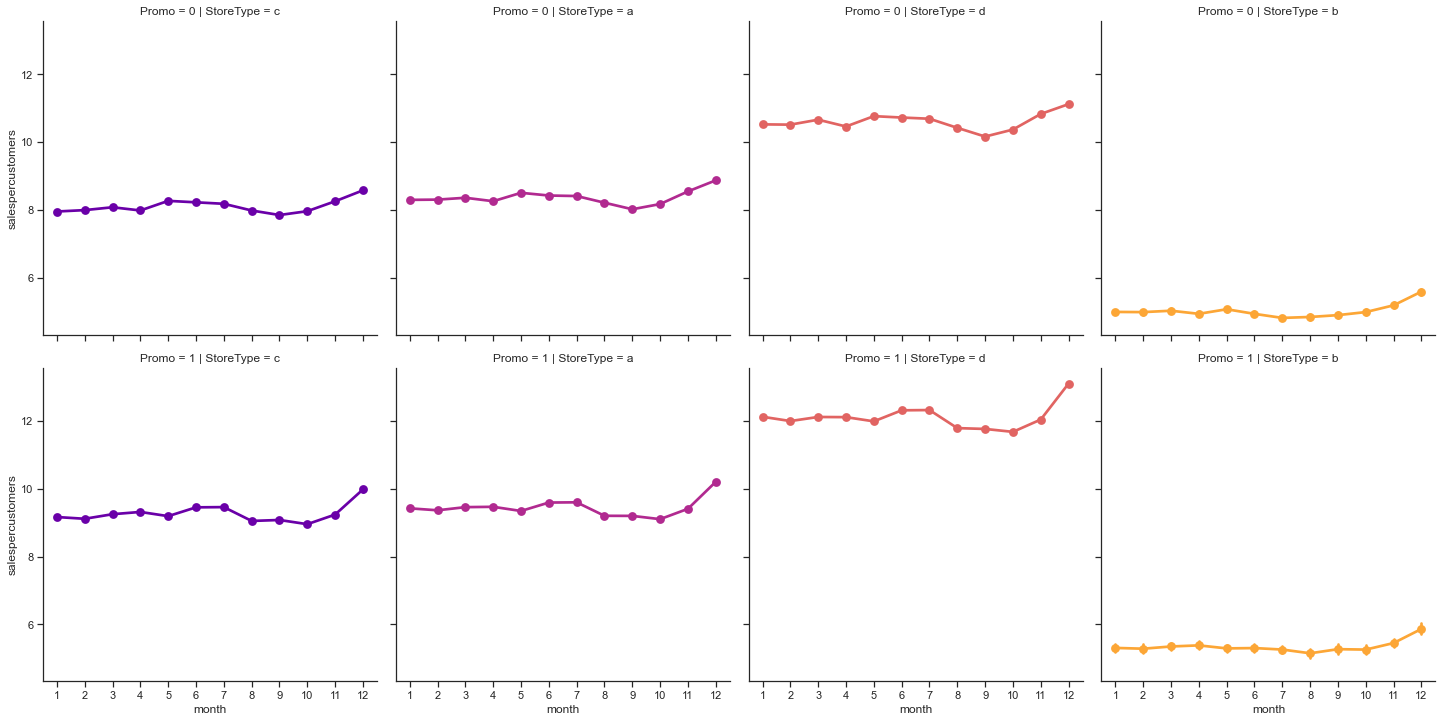

In [94]:
# Tendencia de las ventas
sns.factorplot(data = data, x= 'month', y = 'salespercustomers', col = 'StoreType',
              hue = 'StoreType',
              row= 'Promo', palette = 'plasma')
plt.show()

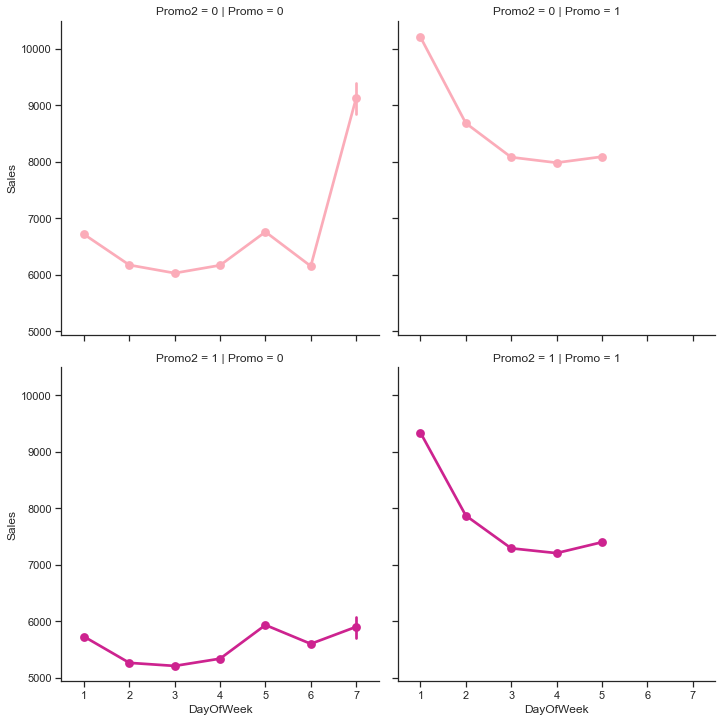

In [96]:
sns.factorplot(data = data, x= 'DayOfWeek', y = 'Sales', col = 'Promo',
              hue = 'Promo2',
              row= 'Promo2', palette = 'RdPu')
plt.show()

**Comentarios**:
- La tendencia de las ventas con promocion es ascendente
- el mes con mayor tendencia ascendente es diciembre
- Los dias que no participa de promocion de mayor venta son viernes y domingo
- Los lunes cunado hay promocion

### Times Series
#### Seasonality

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Tomamos cuatro tiendas de los tipos de tiendas para representar su grupo:

- Tienda número 2 para StoreType A
- Número de tienda 85 para StoreType B,
- Tienda número 1 para StoreType C
- Tienda número 13 para StoreType D.

In [115]:
train['Sales'] = train['Sales'].astype('float')

In [125]:
store_a =train[train['Store'] ==2]['Sales']
store_b =train[train['Store'] ==85]['Sales'].sort_index(ascending = True)
store_c =train[train['Store'] ==1]['Sales']
store_d =train[train['Store'] ==13]['Sales']

In [127]:
store_a

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
               ...  
2013-01-07    6775.0
2013-01-05    2342.0
2013-01-04    4484.0
2013-01-03    4159.0
2013-01-02    4422.0
Name: Sales, Length: 784, dtype: float64

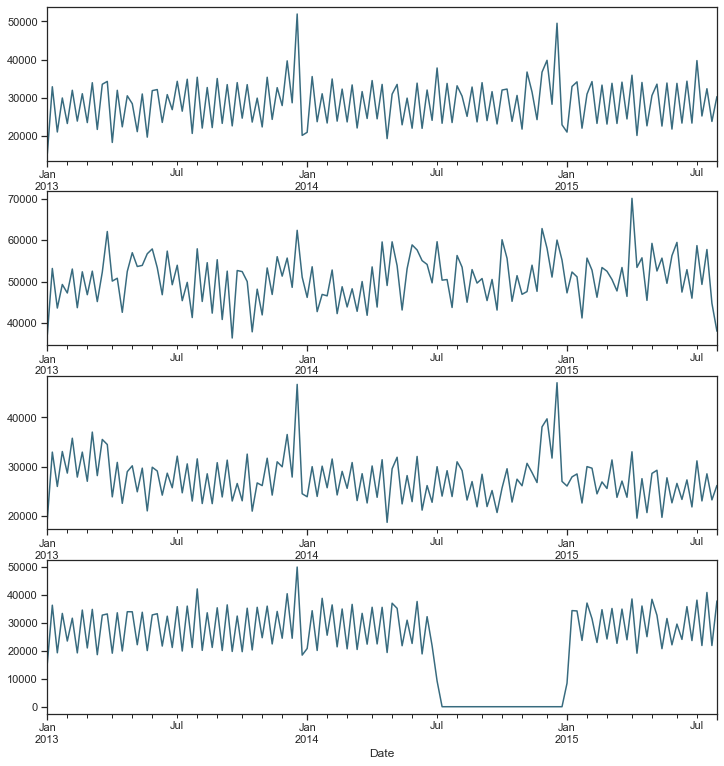

In [130]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
# store types
store_a.resample('W').sum().plot(color = c, ax = ax1)
store_b.resample('W').sum().plot(color = c, ax = ax2)
store_c.resample('W').sum().plot(color = c, ax = ax3)
store_d.resample('W').sum().plot(color = c, ax = ax4)
plt.show()

**Comentarios:** 
- Las ventas por tipo de tienda a y c alcanzan su punto maximo en temporada navideña.
- En las tiendas de tipo D fuera posible su tope maximo en temporada navideña pero no tenemos datos emtre jul 2014 y enero 2015

### Autocorrelation  

El siguiente paso en el análisis de nuestra serie temporal es revisar los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF).  

ACF es una medida de la correlación entre la serie temporal con una versión retrasada de sí misma. Por ejemplo, en el retraso 5, ACF compararía series en el instante de tiempo "t1" ... "tn" con series en el instante "t1-5" ... "tn-5" (t1-5 y tn son puntos finales).  

PACF, por otro lado, mide la correlación entre las series temporales con una versión rezagada de sí misma, pero después de eliminar las variaciones explicadas por las comparaciones intermedias. P.ej. en el rezago 5, comprobará la correlación pero eliminará los efectos ya explicados por los rezagos 1 a 4.

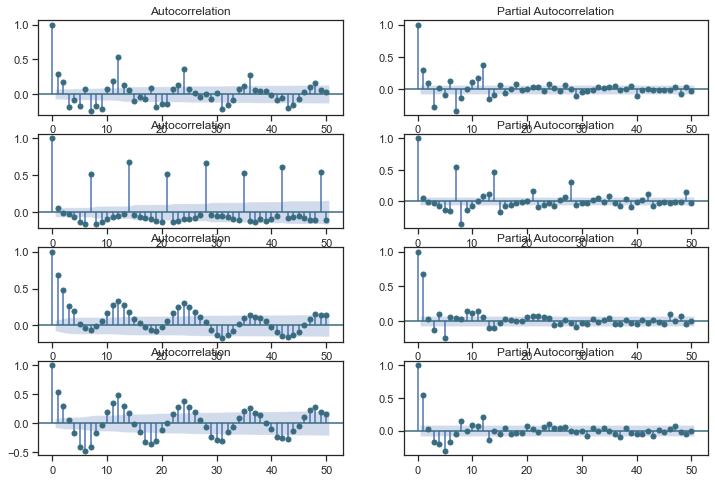

In [132]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(store_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(store_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(store_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(store_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(store_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(store_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(store_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(store_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

Podemos leer estos gráficos horizontalmente. Cada par horizontal es para un 'StoreType', de A a D. En general, esos gráficos muestran la correlación de la serie consigo misma, rezagada por x unidades de tiempo correlación de la serie consigo misma, rezagada por x unidades de tiempo.  

- Hay dos cosas en común para cada par de gráficos: no aleatorias de la serie de tiempo y alto retardo-1 (que probablemente necesitará un orden superior de diferenciación d / D).

- Tipo A y tipo B: ambos tipos muestran estacionalidades en ciertos rezagos. Para el tipo A, es cada duodécima observación con picos positivos en los retrasos 12 (s) y 24 (2s) y así sucesivamente. Para el tipo B, es una tendencia semanal con picos positivos en los retrasos 7 (s), 14 (2 s), 21 (3 s) y 28 (4 s).
- Tipo C y tipo D: las parcelas de estos dos tipos son más complejas. Parece que cada observación está correlacionada con sus observaciones adyacentes.